In [1]:
# process_image.ipynb
# Created 2-10-20 by Eric Graves
# Process an image to "skullphone-ize" it.

## Imports and environment setup

In [27]:
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import sys
from PIL import Image, ImageDraw

%matplotlib inline

# DEBUG shows input and output images, DEBUG_VERBOSE shows images and sizes at each step
DEBUG = True

# This parameter sets how much the image is scaled before processing: 
#-- Smaller image ==> more loss, but faster processing
#-- Just divides the image dimensions in pixels, good values are between 1 and 10. Any smaller and there is a lot of loss of detail/accent colors.
IMAGE_SCALE = 15 
    
# The number of clusters for k-means image color processing
NUM_CLUSTERS = 5
    
# Single test image name
TEST_IMAGE = 'IMG_3723_ART.PNG'# Brockhampton Saturation III album art

IMAGE_SCALE = 20

## Convert image into an array of RGB values
- This cell was just for my planning of the conversion, but is not actually needed in running the actual conversion besides loading the image.

RGBA
(29, 29, 4)


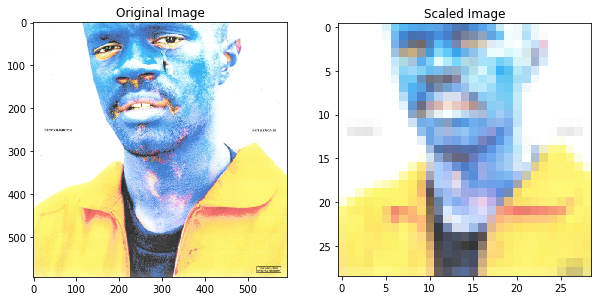

In [28]:
# Read image, set size
img = plt.imread(TEST_IMAGE, 0)
img_PIL = Image.open(TEST_IMAGE) # image opened in RGBA format: size=(x, y, 4[RGBA]) 
h,w = img.shape[:2]

# Resize image
img_resized = img_PIL.resize(((int)(h/IMAGE_SCALE), (int)(w/IMAGE_SCALE)))
img_rs_px = np.array(img_resized) # as numpy array
h_rs, w_rs = img_rs_px.shape[:2]

# Show the original and scaled images
if DEBUG:
    print(img_PIL.mode)
    print(img_rs_px.shape)
    fig = plt.figure(figsize = (10,20))
    p_orig = fig.add_subplot(2,2,1)
    p_orig.set_title("Original Image")
    plt.imshow(img) 
    p_scaled = fig.add_subplot(2,2,2)
    p_scaled.set_title("Scaled Image")
    plt.imshow(img_resized) 
    plt.show()
    
# Allocate output array
img_rgb = np.empty((h_rs, w_rs, 3), dtype=np.uint8)

# TODO: decide if a FSCS on the image would be useful. It may make the image more clear, but at the same time 
#       expose unnatural features.

row_index = -1

# For each pixel in the image
for row in img_rs_px:
    row_index +=1
    px_index = -1
    for px in row:
        px_index +=1
        # Extract color values
        (r, g, b) = px[:3]
        
        # Append to output array
        img_rgb[row_index, px_index, 0] = r
        img_rgb[row_index, px_index, 1] = g
        img_rgb[row_index, px_index, 2] = b # there is probably a better way to do this with np.concatenate, but need to mess with array dimensions so that they match

        
#print(img_rgb[1], img_rgb[2], img_rgb[3])


## Send output to CRT style output image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


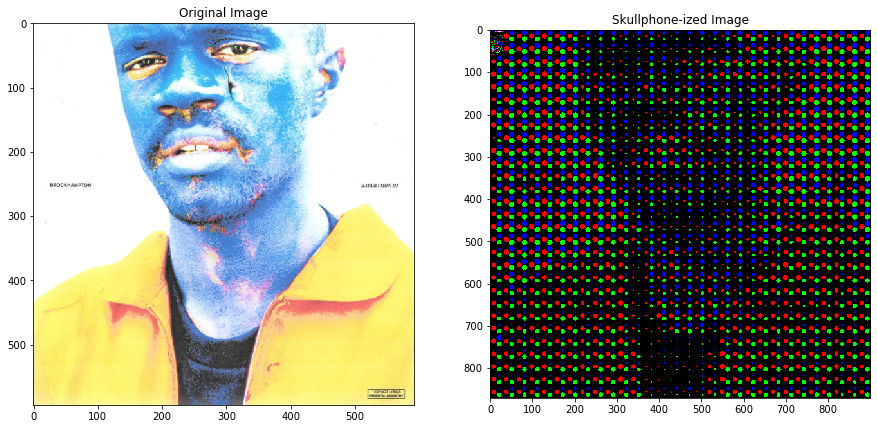

In [29]:
# Px values range: [0, 255] (uint8)
# Resulting image will have shape (w_rs, h_rs)

# First: display single cluster in CRT style:

# Cluster dimension
cluster_d = 30

# Decide circle center offsets: as percentages of d
r_off = np.array((0.27, 0.5))
b_off = np.array((0.73, 0.25))
g_off = np.array((0.73, 0.75)) # TODO: rewrite as single array

# Find circle centers as (x,y)
r_xy = np.uint8(cluster_d * r_off)
b_xy = np.uint8(cluster_d * b_off)
g_xy = np.uint8(cluster_d * g_off)

# Find maximum allowable circle radius
rad_max = np.uint8(0.22* cluster_d)
rad_min = 0 # single px as min

# Scale RGB circle radii: 
#-- RGB value takes range: [0, 255]
#-- Thus normalize each RGB intensity by 255 (cast to float),
#-- Then multiply the result by the maximum allowable radius (cast to uint8), giving displayable radius.

out_img = np.empty((1,900,3)) # placeholder for output image: single px high, 900 px wide

for row in img_rs_px:
    
    cur_row = np.empty((cluster_d,cluster_d,3)) # placeholder for temporary image of a row
    
    for px in row:

        # Extract color values
        (r, g, b) = px[:3]
        
        # Draw cluster background
        img_bg = np.zeros((cluster_d,cluster_d,3))
        
        # Draw each RGB circle, scale radii based on normalized values
        img_r = cv.circle(img_bg, tuple(r_xy), np.uint8((r / 255)*rad_max), [255,0,0], thickness=-1)
        img_rg = cv.circle(img_r, tuple(g_xy), np.uint8((g / 255)*rad_max), [0,255,0], thickness=-1)
        img_rgb = cv.circle(img_rg, tuple(b_xy), np.uint8((b / 255)*rad_max), [0,0,255], thickness=-1)
        
        # Concat cluster images in row together
        cur_row = cv.hconcat([cur_row, img_rgb]) 
    
    # Concat row images together images 
    out_img = cv.vconcat([out_img, cur_row])
        
# Display original and skullphoneized images 
fig = plt.figure(figsize = (15,30))
p_orig = fig.add_subplot(2,2,1)
p_orig.set_title("Original Image")
plt.imshow(img) 
p_scaled = fig.add_subplot(2,2,2)
p_scaled.set_title("Skullphone-ized Image")
plt.imshow(out_img) 
plt.show()